In [1]:
import knn_mi_comp as kmc
import dynamical_systems_routines as dsr
import dmd_routines as dmd
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sci
from copy import copy
%matplotlib inline

In [2]:
def lagged_model_cmp(ydata, kmats, lags):
    pdim, nsteps = ydata.shape    
    mxlag = lags[-1]
    model = np.zeros((pdim, nsteps), dtype=np.float64)
    model[:, :mxlag] = ydata[:, :mxlag]
    for jj in range(nsteps-mxlag):
        tstep = jj + mxlag
        for cnt, lag in enumerate(lags[::-1]):
            if pdim > 1:
                model[:, tstep] += kmats[:, pdim*cnt:pdim*(cnt+1)] @ model[:, tstep - lag]
            else:
                model[:, tstep] += kmats[:, cnt] * model[:, tstep - lag]
    return model

In [3]:
def lagged_dmd_cmp(ydata,lags):
    pdim, nsteps = ydata.shape
    mxlag = lags[-1]
    ypos = ydata[:, mxlag:]
    yneg = np.zeros((len(lags)*pdim, nsteps-mxlag), dtype=np.float64)
    for cnt, lag in enumerate(lags[::-1]):
        yneg[cnt*pdim:(cnt+1)*pdim, :] = ydata[:, mxlag-lag:-lag]
    kmatstmp = sci.lstsq(yneg.T, ypos.T, cond=1e-15, lapack_driver='gelsd')
    #print(np.shape(kmatstmp[0].T))
    #print(np.linalg.norm(ypos.T - yneg.T @ kmatstmp[0])/np.linalg.norm(ypos))
    kmats = kmatstmp[0].T     
    return kmats

In [4]:
def it_dmd(max_lag, ydata):
    # ground expectation
    thrshhld = 15
    knghbr = 3
    kmatl = dmd.dmd_cmp(ydata[:, :-1], ydata[:, 1:], thrshhld)

    kmats = kmatl
    chosen_lags = [1]    

    # forward build
    significant = True
    remaining_lags = np.arange(2, max_lag)
    
    while significant:
        cmi_max = 0.01
        triggered = False
        for lcnt, lag in enumerate(remaining_lags):            
            xvals = ydata[:, lag:]                                    
            zvals = lagged_model_cmp(ydata, kmats, chosen_lags)                
            prop_lags = chosen_lags + [lag]         
            kmats_prop = lagged_dmd_cmp(ydata, prop_lags)
            
            yvals = lagged_model_cmp(ydata, kmats_prop, prop_lags)
            cmi = kmc.cmiknn(xvals.T, yvals[:, lag:].T, zvals[:, lag:].T, knghbr)
            if cmi > cmi_max:
                cmi_max = cmi
                clag = lag
                ccnt = lcnt
                chosenkmats = copy(kmats_prop)
                xvalsmax = copy(xvals)
                yvalsmax = copy(yvals[:, lag:])                
                zvalsmax = copy(zvals[:, lag:])
                triggered = True

        if triggered:        
            dist = kmc.shuffle_test(xvalsmax.T, yvalsmax.T, zvalsmax.T, knghbr)
            if dist.cdf.evaluate(cmi_max) < .99:
                significant = False                
            else:
                chosen_lags.append(clag)
                kmats = copy(chosenkmats)
                if clag == max_lag:
                    significant = False
                else:
                    remaining_lags = np.delete(remaining_lags, np.arange(ccnt+1))
        else:
            significant = False

    print("Current choices for lags are:")
    print(chosen_lags)
    
    # backward prune
    if len(chosen_lags) > 2:
     
        yvalsmin = lagged_model_cmp(ydata, kmats, chosen_lags)
        while not(significant):
            xvalsmin = ydata[:, chosen_lags[-1]:]        
            cmi_min = 1e6
            for cnt, lag in enumerate(chosen_lags[1:]):
                
                prop_lags = chosen_lags[:cnt+1] + chosen_lags[cnt+2:]
                kmats_prop = lagged_dmd_cmp(ydata, prop_lags)
                zvals = lagged_model_cmp(ydata, kmats_prop, prop_lags)
                cmi = kmc.cmiknn(xvalsmin.T, yvalsmin[:, chosen_lags[-1]:].T, zvals[:, chosen_lags[-1]:].T, knghbr)                
                if cmi < cmi_min:
                    cmi_min = cmi
                    ccnt = cnt + 1
                    zvalsmin = copy(zvals)
                    chosenkmats = copy(kmats_prop)
                    
            dist = kmc.shuffle_test(xvalsmin.T, yvalsmin[:, chosen_lags[-1]:].T, zvalsmin[:, chosen_lags[-1]:].T, knghbr)
            pval = dist.cdf.evaluate(np.abs(cmi_min))
            
            if  pval < .99 and len(chosen_lags)>2:
                poppedcnt = chosen_lags.pop(ccnt)
                kmats = copy(chosenkmats)
                yvalsmin = copy(zvalsmin)
            else:
                significant = True
        
    return kmats, chosen_lags

In [5]:
xbnd = 10.
dt = .01
tf = 22.
ldata = dsr.generate_lorenz63(-xbnd, xbnd, -xbnd, xbnd,-xbnd, xbnd, 100, dt, tf, seed=1973)
#ldata = dsr.generate_vanderpol(-xbnd, xbnd, -xbnd, xbnd, 100, dt, tf, seed=1973)

Generating Lorenz63 system data...: 100%|█████████████████████████| 100/100 [00:15<00:00,  6.62it/s]


In [6]:
ldata0 = np.squeeze(ldata[0, :, :])
xvals = ldata0[0, :].reshape(-1,1)
yvals = ldata0[1, :].reshape(-1,1)
zvals = ldata0[2, :].reshape(-1,1)
i012 = kmc.cmiknn(xvals[1:], yvals[:-1], zvals[:-1], 3)

In [7]:
print(i012)

1.9277843120566316


In [10]:
edist = kmc.shuffle_test(xvals[1:], yvals[:-1], zvals[:-1], 3)

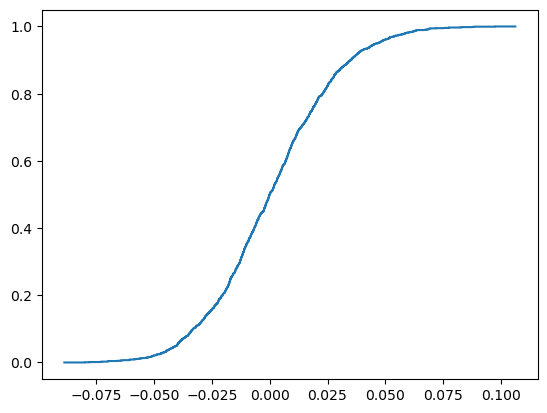

In [11]:
ax = plt.subplot()
edist.cdf.plot(ax)

In [12]:
print(edist.cdf.evaluate(i012))

1.0


In [7]:
tstpsback = int(.4/dt)
skp = int(20./dt)
nsteps = int(tf/dt) + 1
tfull = np.linspace(0,tf,nsteps)
tseries = np.squeeze(ldata[10, :, skp:])
tskp = tfull[skp:]
training = tseries[:, :-tstpsback]

#pdim = training.shape[0]
#for jj in range(pdim):
#    avg = np.mean(training[jj, :])
#    sig = np.sqrt(np.mean( (training[jj, :] - avg)**2. ))
#    training[jj, :] = (training[jj, :] - avg)/sig

#test = tseries[:, -tstpsback:]
#print(np.shape(training))
#tmean = np.mean(training, 1)
#training = training - np.tile(np.mean(training, 1).reshape(-1, 1), training.shape[1])

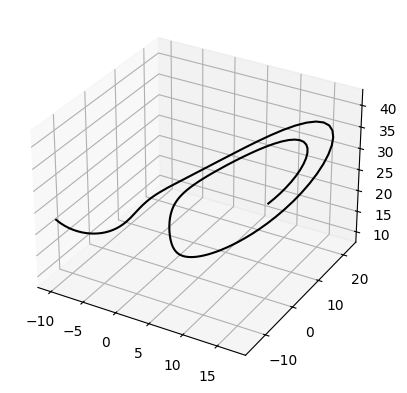

In [8]:
ax = plt.axes(projection='3d')
ax.plot3D(training[0, :], training[1, :], training[2, :], 'black')

In [9]:
#u, s, vh = np.linalg.svd(training, full_matrices=False)
#print(s)
#training = u.T @ training
#treduced = training[:-1, :]
#ax = plt.axes(projection='3d')
#ax.plot3D(training[0, :], training[1, :], training[2, :], 'black')

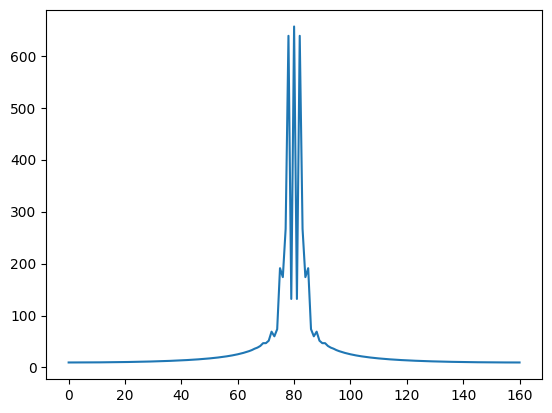

In [10]:
plt.plot(np.fft.fftshift(np.abs(np.fft.fft(training[0,:]))))

In [17]:
max_lag = 10
#chosen_kmats, chosen_lags = it_dmd(max_lag, treduced[0, :].reshape(1,-1))
#ed_model = lagged_model_cmp(treduced[0, :].reshape(1,-1), chosen_kmats, chosen_lags)

chosen_kmats, chosen_lags = it_dmd(max_lag, training)
ed_model = lagged_model_cmp(training, chosen_kmats, chosen_lags)

print("Final lag choices are:")
print(chosen_lags)

Current choices for lags are:
[1, 7, 9]
Final lag choices are:
[1, 7, 9]


In [18]:
max_all_lag = 10
all_lags = list(np.arange(1, max_all_lag))

#all_kmats = lagged_dmd_cmp(treduced[0, :].reshape(1,-1), all_lags)
#all_model = lagged_model_cmp(treduced[0, :].reshape(1,-1), all_kmats, all_lags)

all_kmats = lagged_dmd_cmp(training, all_lags)
all_model = lagged_model_cmp(training, all_kmats, all_lags)

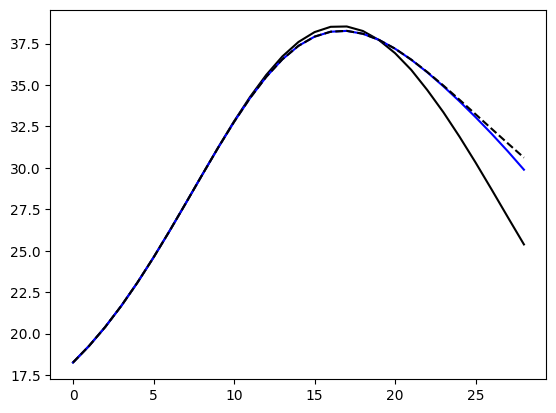

In [22]:
#plt.plot(forecasts[0, :])
dim = 2
thorizon = chosen_lags[-1] + 20
plt.plot(ed_model[dim,:thorizon], c='k')
plt.plot(all_model[dim, :thorizon], c='b')
plt.plot(training[dim, :thorizon], c='k', ls='--')
#plt.plot(forecasts[dim, chosen_lags[-1]:], c='k')
#plt.plot(dmd_only[dim, chosen_lags[-1]:], c='r')
#plt.plot(test[dim, :], c='b')

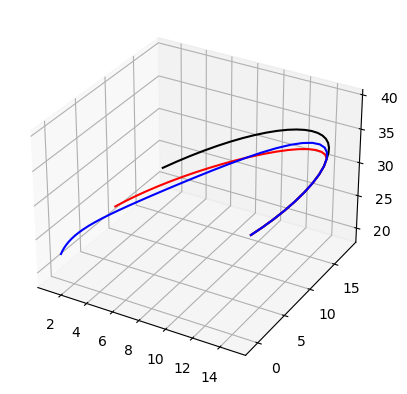

In [15]:
ax = plt.axes(projection='3d')
ax.plot3D(forecasts[0, :], forecasts[1, :], forecasts[2, :], 'black')
ax.plot3D(no_it[0, :], no_it[1, :], no_it[2, :], 'red')
ax.plot3D(training[0, :tstpsback+chosen_lags[-1]], training[1, :tstpsback+chosen_lags[-1]], training[2, :tstpsback+chosen_lags[-1]], 'blue')
